# Capstone Final 24.1 — Analysis
### ----------------------------------------------------------
- Title: Buy vs Rent Decision Analysis
- Author: Siddarth R Mannem
- Course: AI/ML Professional Certificate - Capstone 24.1
### ----------------------------------------------------------

## 03_scenario_analysis.ipynb
**Buy vs. Rent in 2025–2026: ZIP-Level Cash-Flow Comparison**

### Purpose
Conduct **scenario and sensitivity analysis** on the 5‑year **NPV cost difference** between buying and renting at the ZIP level, building on the modeling outputs from `02_cost_projection_model.ipynb`.

### Description
1. **Load** `model_training_frame_v2.csv` (scenario-ready snapshot) and optional `preprocess_fitted.pkl` if ML approximations are desired.  
2. **Define scenarios** that perturb key drivers (mortgage rate, property tax rate, insurance %, maintenance %, HOA) within realistic ranges.  
3. **Recompute NPV delta** deterministically under each scenario using the same finance rules as the modeling step.  
4. **Summarize** results: share of ZIPs where **Buy** is cheaper, average NPV delta, **flip rate** (rent↔buy), and by‑state/metro rollups.  
5. **Visualize** sensitivity lines, bar charts, and state/metro comparisons; export CSVs for your deck.

### Goals
- Provide transparent, course‑aligned scenario results that stakeholders can interpret.  
- Quantify **how much** each variable moves the Buy vs Rent decision.  
- Produce **exportable tables/figures** for Module 24’s presentation.

> Methods are aligned with **Modules 1–23**: problem framing & EDA (M1–6), linear modeling baselines and regularization (M7–9), tree ensembles (M15), validation design (M12–13), and clear communication & visuals (M3, M14).

## 0. CONFIG

In [1]:

# ------------------------------
# CONFIG: Import, Config, Paths & Settings
# ------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive
import os


# Update to your Drive path if using Colab
pd.set_option('display.float_format', lambda x: '%.4f' % x)

drive.mount('/content/drive')
capstone_data_base_path = '/content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/'
capstone_figures_path = '/content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/figures/analysis/'

try:
    DATA_DIR = Path(capstone_data_base_path)
except NameError:
    DATA_DIR = Path('/mnt/data')

ARTIFACTS = Path(capstone_data_base_path + 'artifacts')  # also where preprocess_fitted.pkl may be
ARTIFACTS.mkdir(parents=True, exist_ok=True)

INPUT_CSV = DATA_DIR / 'model_training_frame_v2.csv'
PREPROCESS_PKL = DATA_DIR / 'preprocess_fitted.pkl'  # saved at end of Section 6

print('Data dir:', DATA_DIR)
print('Input CSV exists:', INPUT_CSV.exists())
print('Preprocess PKL exists:', PREPROCESS_PKL.exists())
print('Artifacts dir:', ARTIFACTS)
print('Figures dir:', capstone_figures_path)
print('✅ Ready!')


Mounted at /content/drive
Data dir: /content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2
Input CSV exists: True
Preprocess PKL exists: True
Artifacts dir: /content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/artifacts
Figures dir: /content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/figures/analysis/
✅ Ready!


## 1. Load Scenario-Ready Data

In [ ]:

import pandas as pd
import numpy as np

df = pd.read_csv(INPUT_CSV)
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
if 'year' in df.columns:
    df['year'] = pd.to_numeric(df['year'], errors='coerce')

print('Rows:', len(df))
display(df.head(3))

# Basic checks for expected columns (use fallbacks if absent)
defaults = {
    'tax_rate_3yr_avg': 0.012,
    'insurance_pct': 0.003,
    'maintenance_pct': 0.01,
    'hoa_monthly': 0.0
}
for c, val in defaults.items():
    if c not in df.columns:
        df[c] = val
    else:
        df[c] = df[c].fillna(val)


Rows: 395376


,zip,state,Metro,date,year,median_price,median_rent,mortgage_rate,tax_rate_3yr_avg,insurance_pct,maintenance_pct,price_to_rent_years,property_tax_dollar,growth_spread,npv_buy,npv_rent,delta_buy_minus_rent,mortgage_monthly,sale_price_yearH,buy_cheaper
0,1002,MA,"Springfield, MA",2023-08-01,2023,481709,2587,0.0681,NaN,NaN,NaN,15.5170,5780.5080,0.0000,211148.9647,151843.9559,59305.0088,2514.8734,521417.3134,0
1,1002,MA,"Springfield, MA",2023-09-01,2023,485690,2588,0.0718,NaN,NaN,NaN,15.6392,5828.2800,0.0000,218198.8905,151902.2084,66296.6821,2632.1866,525726.4758,0
2,1002,MA,"Springfield, MA",2023-10-01,2023,489825,2562,0.0731,NaN,NaN,NaN,15.9324,5877.9000,0.0000,221955.0689,150387.6452,71567.4236,2689.1418,530202.3328,0


## 2. Finance Engine (same rules as 02*)

In [ ]:

# Deterministic cash-flow computation under scenario perturbations.
# Keep consistent with 02_cost_projection_model assumptions.

CONFIG = {
    "horizon_years": 5,
    "loan_term_years": 30,
    "discount_rate_yr": 0.03,
    "down_payment_pct": 0.20,
    "closing_cost_pct": 0.02,
    "selling_cost_pct": 0.06,
    "property_tax_growth_yr": 0.02,
    "insurance_growth_yr": 0.02,
    "hoa_growth_yr": 0.02,
    "maintenance_growth_yr": 0.02,
    # Baseline annual growth if explicit growth columns are missing
    "price_appreciation_yr": 0.02,
    "rent_growth_yr": 0.03,
    "renters_insurance_yr": 250.0,
}

def amortization_payment(principal, annual_rate, years):
    r = (annual_rate or 0) / 12.0
    n = years * 12
    if r == 0:
        return principal / n if n else 0.0
    return principal * (r * (1 + r)**n) / ((1 + r)**n - 1)

def npv_delta_for_row(row, cfg,
                      mort_rate=None, tax_rate=None, ins_pct=None, maint_pct=None, hoa_mo=None,
                      price_app=None, rent_growth=None):
    P = float(row.get('median_price', np.nan))
    R0 = float(row.get('median_rent', np.nan))

    mort_rate = float(mort_rate if mort_rate is not None else row.get('mortgage_rate', np.nan))
    tax_rate  = float(tax_rate  if tax_rate  is not None else row.get('tax_rate_3yr_avg', cfg['property_tax_growth_yr']))
    ins_pct   = float(ins_pct   if ins_pct   is not None else row.get('insurance_pct', 0.003))
    maint_pct = float(maint_pct if maint_pct is not None else row.get('maintenance_pct', 0.01))
    hoa_mo    = float(hoa_mo    if hoa_mo    is not None else row.get('hoa_monthly', 0.0))

    price_app   = float(price_app   if price_app   is not None else row.get('median_price_growth', cfg['price_appreciation_yr']))
    rent_growth = float(rent_growth if rent_growth is not None else row.get('median_rent_growth', cfg['rent_growth_yr']))

    H = cfg["horizon_years"]
    disc = cfg["discount_rate_yr"]
    down = cfg["down_payment_pct"]
    close_pct = cfg["closing_cost_pct"]
    sell_pct  = cfg["selling_cost_pct"]

    # Upfront & mortgage
    dp = P * down
    loan_amt = max(P - dp, 0.0)
    mo_pmt = amortization_payment(loan_amt, mort_rate, cfg["loan_term_years"])

    # Annual base costs
    tax_yr = P * tax_rate
    ins_yr = P * ins_pct
    maint_yr = P * maint_pct
    hoa_yr = hoa_mo * 12.0

    def disc_factor(y): return (1.0 / ((1.0 + disc) ** y))

    npv_buy = dp + P * close_pct
    npv_rent = 0.0

    price_t = P
    rent_t  = R0

    for y in range(1, H + 1):
        if y > 1:
            tax_yr   *= (1 + cfg["property_tax_growth_yr"])
            ins_yr   *= (1 + cfg["insurance_growth_yr"])
            maint_yr *= (1 + cfg["maintenance_growth_yr"])
            hoa_yr   *= (1 + cfg["hoa_growth_yr"])
            price_t  *= (1 + price_app)
            rent_t   *= (1 + rent_growth)

        year_mort = mo_pmt * 12.0
        cost_buy_y = year_mort + tax_yr + ins_yr + maint_yr + hoa_yr
        cost_rent_y = rent_t * 12.0 + cfg["renters_insurance_yr"]

        npv_buy  += cost_buy_y * disc_factor(y)
        npv_rent += cost_rent_y * disc_factor(y)

    sale_price = price_t
    selling_costs = sale_price * sell_pct
    equity_proxy = dp + (sale_price - P)
    recovered_equity = max(equity_proxy - selling_costs, 0.0)
    npv_buy -= recovered_equity * disc_factor(H)

    return npv_buy - npv_rent  # <0 → Buy cheaper


## 3. Define Scenarios

In [ ]:

# Named scenarios: multipliers/adders applied to baseline columns
SCENARIOS = {
    'Base':         {'mort_mult': 1.00, 'tax_add': 0.000, 'ins_mult': 1.00, 'maint_mult': 1.00, 'hoa_mult': 1.00},
    'LowRates':     {'mort_mult': 0.90, 'tax_add': 0.000, 'ins_mult': 1.00, 'maint_mult': 1.00, 'hoa_mult': 1.00},
    'HighRates':    {'mort_mult': 1.25, 'tax_add': 0.000, 'ins_mult': 1.00, 'maint_mult': 1.00, 'hoa_mult': 1.00},
    'HighTax':      {'mort_mult': 1.00, 'tax_add': 0.002, 'ins_mult': 1.00, 'maint_mult': 1.00, 'hoa_mult': 1.00},
    'HighIns':      {'mort_mult': 1.00, 'tax_add': 0.000, 'ins_mult': 1.20, 'maint_mult': 1.00, 'hoa_mult': 1.00},
    'HighMaint':    {'mort_mult': 1.00, 'tax_add': 0.000, 'ins_mult': 1.00, 'maint_mult': 1.20, 'hoa_mult': 1.00},
    'HighHOA':      {'mort_mult': 1.00, 'tax_add': 0.000, 'ins_mult': 1.00, 'maint_mult': 1.00, 'hoa_mult': 1.20},
}

# Optional mortgage-rate grid for sensitivity lines (±200 bps around median)
mort_grid = np.round(np.linspace(0.80, 1.25, 10), 2)  # multipliers


## 4. Compute Scenario Outcomes

In [ ]:

def apply_scenario(df_in, scen_name, params):
    d = df_in.copy()
    # Build altered inputs
    mort = d['mortgage_rate'] * params['mort_mult']
    tax  = d['tax_rate_3yr_avg'] + params['tax_add']
    ins  = d['insurance_pct'] * params['ins_mult']
    maint= d['maintenance_pct'] * params['maint_mult']
    hoa  = (d['hoa_monthly'] if 'hoa_monthly' in d.columns else 0.0) * params['hoa_mult']

    # Recompute NPV delta
    deltas = []
    for i, row in d.iterrows():
        deltas.append(npv_delta_for_row(
            row, CONFIG, mort_rate=mort.iloc[i], tax_rate=tax.iloc[i],
            ins_pct=ins.iloc[i], maint_pct=maint.iloc[i],
            hoa_mo=hoa.iloc[i] if hasattr(hoa, 'iloc') else hoa
        ))
    d['delta_scen'] = deltas
    d['buy_cheaper_scen'] = (d['delta_scen'] < 0).astype(int)
    d['scenario'] = scen_name
    return d

# Run named scenarios
frames = []
for name, p in SCENARIOS.items():
    frames.append(apply_scenario(df, name, p))

scenario_df = pd.concat(frames, ignore_index=True)
print('Scenario results rows:', len(scenario_df))
display(scenario_df.head(3))


Scenario results rows: 2767632


,zip,state,Metro,date,year,median_price,median_rent,mortgage_rate,tax_rate_3yr_avg,insurance_pct,...,npv_buy,npv_rent,delta_buy_minus_rent,mortgage_monthly,sale_price_yearH,buy_cheaper,hoa_monthly,delta_scen,buy_cheaper_scen,scenario
0,1002,MA,"Springfield, MA",2023-08-01,2023,481709,2587,0.0681,0.0120,0.0030,...,211148.9647,151843.9559,59305.0088,2514.8734,521417.3134,0,0.0000,59305.0088,0,Base
1,1002,MA,"Springfield, MA",2023-09-01,2023,485690,2588,0.0718,0.0120,0.0030,...,218198.8905,151902.2084,66296.6821,2632.1866,525726.4758,0,0.0000,66296.6821,0,Base
2,1002,MA,"Springfield, MA",2023-10-01,2023,489825,2562,0.0731,0.0120,0.0030,...,221955.0689,150387.6452,71567.4236,2689.1418,530202.3328,0,0.0000,71567.4236,0,Base


## 5. Aggregations & KPIs

In [ ]:
# Overall KPIs per scenario
kpi_overall = (scenario_df
    .groupby('scenario')
    .agg(
        buy_share=('buy_cheaper_scen','mean'),
        avg_delta=('delta_scen','mean'),
        median_delta=('delta_scen','median'),
    )
    .reset_index()
)

# Flip rate: fraction of ZIPs whose decision changed vs baseline (Base)
base_mask = scenario_df['scenario'] == 'Base'
base = scenario_df[base_mask][['zip','buy_cheaper_scen']].rename(columns={'buy_cheaper_scen':'base_buy'})
flips = []
for scen in scenario_df['scenario'].unique():
    if scen == 'Base':
        flips.append({'scenario':'Base','flip_rate':0.0})
        continue
    comp = scenario_df[scenario_df['scenario']==scen][['zip','buy_cheaper_scen']].merge(base, on='zip', how='left')
    rate = (comp['buy_cheaper_scen'] != comp['base_buy']).mean()
    flips.append({'scenario': scen, 'flip_rate': rate})

flips_df = pd.DataFrame(flips)
kpi_overall = kpi_overall.merge(flips_df, on='scenario', how='left')
display(kpi_overall.sort_values('buy_share', ascending=False))

# By-state summary
by_state = (scenario_df
    .groupby(['scenario','state'])
    .agg(buy_share=('buy_cheaper_scen','mean'),
         avg_delta=('delta_scen','mean'),
         count=('zip','nunique'))
    .reset_index())

# By-metro (if present)
if 'Metro' in scenario_df.columns:
    by_metro = (scenario_df
        .groupby(['scenario','Metro'])
        .agg(buy_share=('buy_cheaper_scen','mean'),
             avg_delta=('delta_scen','mean'),
             count=('zip','nunique'))
        .reset_index())
else:
    by_metro = pd.DataFrame()

print('By-state rows:', len(by_state))
display(by_state.head(10))

,scenario,buy_share,avg_delta,median_delta,flip_rate
6,LowRates,0.1431,77539.5059,44725.0931,0.0913
1,HighHOA,0.1248,84717.7263,50250.6941,0.0864
0,Base,0.1248,84717.7263,50250.6941,0.0000
2,HighIns,0.1205,86329.6119,51449.5826,0.0853
5,HighTax,0.1121,89321.6677,53768.5645,0.0839
3,HighMaint,0.1120,89623.3426,53870.8549,0.0839
4,HighRates,0.0886,103500.3999,64840.5227,0.0878


By-state rows: 357


,scenario,state,buy_share,avg_delta,count
0,Base,AK,0.0000,53117.7700,20
1,Base,AL,0.3099,25890.9331,119
2,Base,AR,0.1396,31737.4883,59
3,Base,AZ,0.0344,57617.3278,186
4,Base,CA,0.0001,222746.9996,932
5,Base,CO,0.0108,91331.2735,181
6,Base,CT,0.0448,79464.3387,105
7,Base,DC,0.0096,124473.0276,22
8,Base,DE,0.2170,27721.0526,23
9,Base,FL,0.2081,37604.2402,671


## 6. Visualizations

This section presents various visualizations to help understand the scenario analysis results:

### 6.1 Combined Grid Dashboard

This visualization creates a 2x3 grid displaying:
- Overall Buy Share by Scenario
- Decision Flip Rate vs Base
- NPV Delta Distribution for selected scenarios (HighTax and HighMaint)
- Top 15 States by Buy Share for those selected scenarios.

### 6.2 KPI Cards

This section displays key performance indicators (Buy Share, Avg NPV Delta, Median NPV Delta, Flip Rate) for each scenario as interactive HTML cards.

### 6.3 Scenario Scoreboard

This section presents a styled table summarizing the key KPIs for each scenario, using formatting like data bars and color gradients for easy comparison.

### 6.4 Top/Bottom States Table

This section generates styled tables showing the Top 10 and Bottom 10 states based on Buy Share for a chosen scenario.

### 6.5 Interactive Scenario Dashboard

This section provides an interactive dashboard using `ipywidgets` to explore scenario results by state and metro area with filtering and sorting options.

### 6.6 Tornado Sensitivity Table

This section generates a tornado-style sensitivity table for a single representative ZIP code, showing how the NPV delta changes when individual cost factors (Mortgage Rate, Property Tax, Insurance, Maintenance, HOA) are varied.

In [ ]:

os.makedirs(capstone_figures_path, exist_ok=True)

def annotate_bars(ax, fmt="{:.0%}", offset=0.002):
    """Add value labels to the end of horizontal bars."""
    for p in ax.patches:
        x = p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.text(x + offset, y, fmt.format(x), va="center", ha="left", fontsize=9)

def percentify(series):
    return (series*100).round(1)

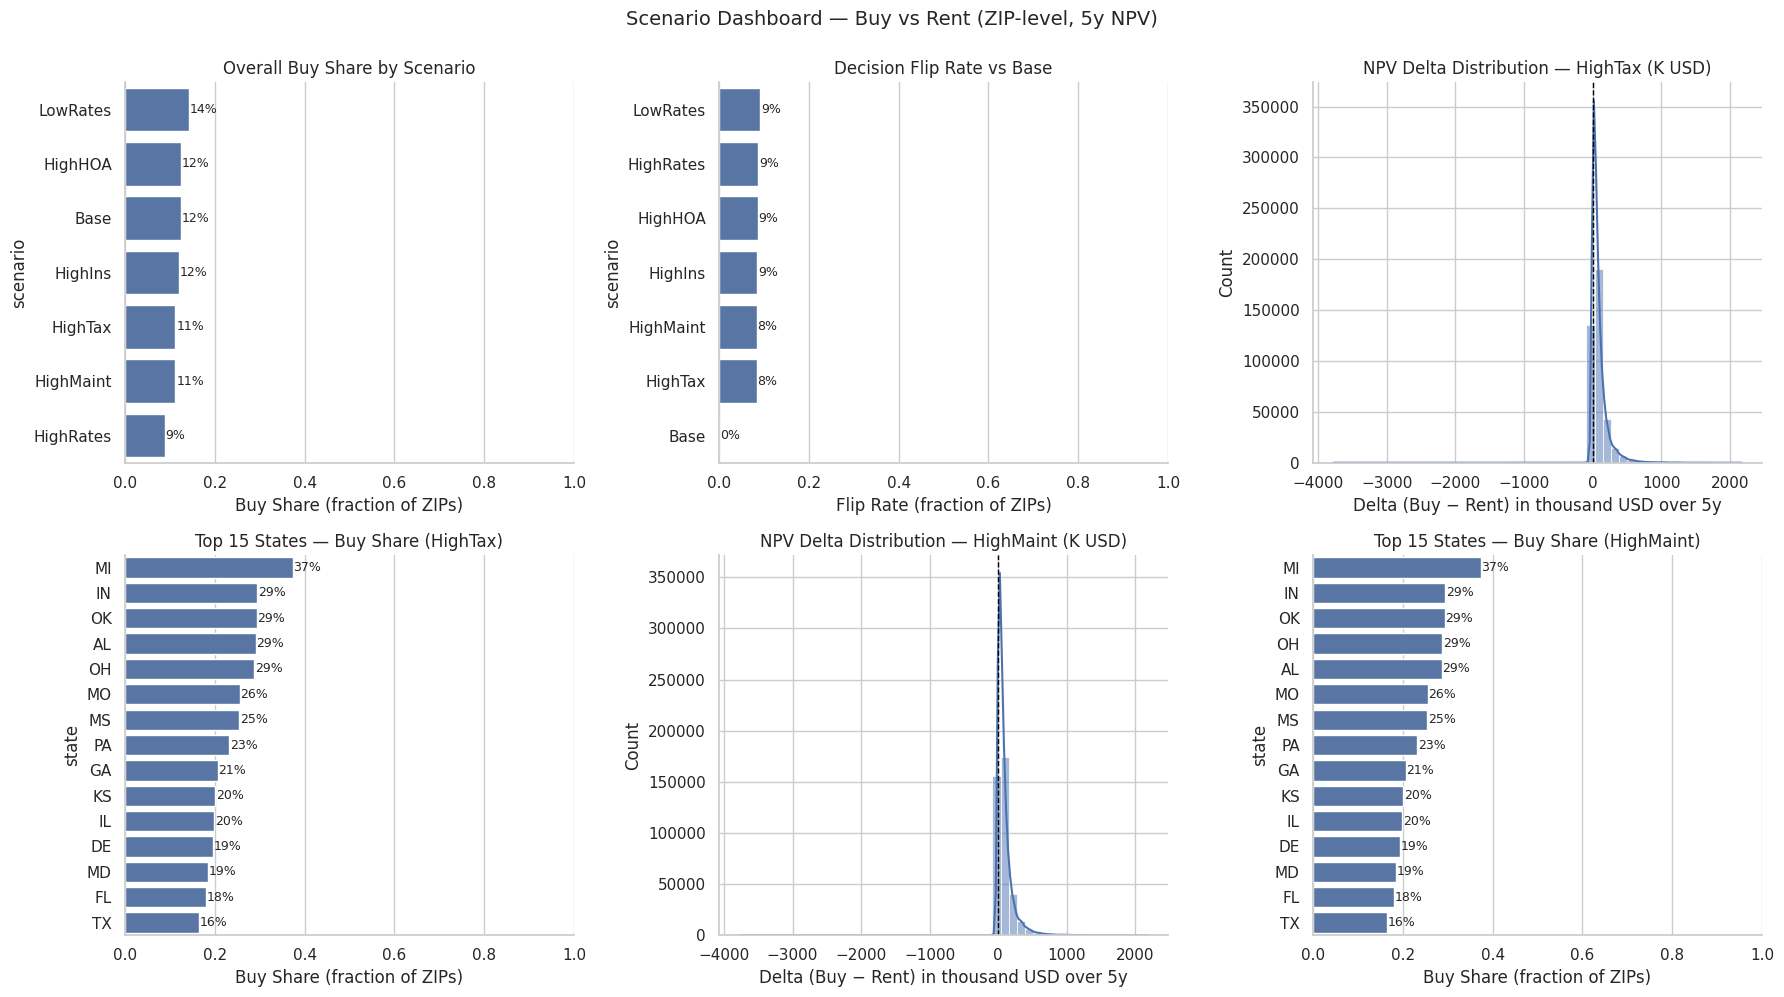

✅ Saved combined grid figure:
/content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/figures/analysis/v6_grid_dashboard.png


In [ ]:
# 6.1. Grid Dashboard — single cell, 2×3 layout (saves one combined image)
# This cell generates a combined 2x3 grid of plots to visualize key scenario analysis results:
#     Overall Buy Share,
#     Flip Rate vs Base,
#     NPV Delta Distribution for selected scenarios,
#     Top 15 States by Buy Share for those scenarios.

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- safety: figures path + helper ----------
try:
    capstone_figures_path
except NameError:
    capstone_figures_path = "./figures/"
os.makedirs(capstone_figures_path, exist_ok=True)

def annotate_bars_ax(ax, fmt="{:.0%}", offset=0.002):
    """Annotate horizontal bars on a specific Axes."""
    for p in ax.patches:
        x = p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.text(x + offset, y, fmt.format(x), va="center", ha="left", fontsize=9)

sns.set_theme(style="whitegrid")

# ---------- prepare data ----------
# 6.1 Overall Buy Share
plot1 = kpi_overall.sort_values('buy_share', ascending=False).copy()

# 6.2 Flip Rate
plot2 = kpi_overall.sort_values('flip_rate', ascending=False).copy()

# 6.3 HighTax panels
scen_A = "HighTax"
sd_A = scenario_df[scenario_df["scenario"]==scen_A].copy()
topA = (sd_A.groupby("state")["buy_cheaper_scen"].mean()
          .sort_values(ascending=False).head(15).reset_index())

# 6.4 HighMaint panels
scen_B = "HighMaint"
sd_B = scenario_df[scenario_df["scenario"]==scen_B].copy()
topB = (sd_B.groupby("state")["buy_cheaper_scen"].mean()
          .sort_values(ascending=False).head(15).reset_index())

# ---------- figure grid ----------
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
(ax11, ax12, ax13), (ax21, ax22, ax23) = axes

# (1,1) Overall Buy Share by Scenario
sns.barplot(data=plot1, x='buy_share', y='scenario', ax=ax11)
ax11.set_title('Overall Buy Share by Scenario')
ax11.set_xlabel('Buy Share (fraction of ZIPs)'); ax11.set_xlim(0, 1)
annotate_bars_ax(ax11, fmt="{:.0%}")

# (1,2) Flip Rate vs Base
sns.barplot(data=plot2, x='flip_rate', y='scenario', ax=ax12)
ax12.set_title('Decision Flip Rate vs Base')
ax12.set_xlabel('Flip Rate (fraction of ZIPs)'); ax12.set_xlim(0, 1)
annotate_bars_ax(ax12, fmt="{:.0%}")

# (1,3) HighTax — NPV Delta Distribution
sns.histplot((sd_A["delta_scen"]/1000.0), bins=50, kde=True, ax=ax13)
ax13.axvline(0, color="black", linestyle="--", linewidth=1)
ax13.set_title(f'NPV Delta Distribution — {scen_A} (K USD)')
ax13.set_xlabel('Delta (Buy − Rent) in thousand USD over 5y')

# (2,1) HighTax — Top 15 States by Buy Share
sns.barplot(data=topA, x="buy_cheaper_scen", y="state", ax=ax21)
ax21.set_title(f"Top 15 States — Buy Share ({scen_A})")
ax21.set_xlabel('Buy Share (fraction of ZIPs)'); ax21.set_xlim(0, 1)
annotate_bars_ax(ax21, fmt="{:.0%}")

# (2,2) HighMaint — NPV Delta Distribution
sns.histplot((sd_B["delta_scen"]/1000.0), bins=50, kde=True, ax=ax22)
ax22.axvline(0, color="black", linestyle="--", linewidth=1)
ax22.set_title(f'NPV Delta Distribution — {scen_B} (K USD)')
ax22.set_xlabel('Delta (Buy − Rent) in thousand USD over 5y')

# (2,3) HighMaint — Top 15 States by Buy Share
sns.barplot(data=topB, x="buy_cheaper_scen", y="state", ax=ax23)
ax23.set_title(f"Top 15 States — Buy Share ({scen_B})")
ax23.set_xlabel('Buy Share (fraction of ZIPs)'); ax23.set_xlim(0, 1)
annotate_bars_ax(ax23, fmt="{:.0%}")

# ---------- finalize ----------
sns.despine(fig)
fig.suptitle("Scenario Dashboard — Buy vs Rent (ZIP-level, 5y NPV)", fontsize=14, y=0.995)
plt.tight_layout()
out_path = os.path.join(capstone_figures_path, "v6_grid_dashboard.png")
plt.savefig(out_path, dpi=180)
plt.show()
print(f"✅ Saved combined grid figure:\n{out_path}")


In [ ]:
# 6.2 KPI Cards — HTML scorecards per scenario (no charts)
from IPython.display import HTML, display
import numpy as np

def pct(x):
    return f"{100*x:.1f}%" if np.isfinite(x) else "–"
def usd(x):
    return f"${x:,.0f}" if np.isfinite(x) else "–"

cards = []
for r in kpi_overall.sort_values('buy_share', ascending=False).itertuples():
    card = f"""
    <div style="display:inline-block; width: 260px; margin:8px; padding:14px;
                border-radius:12px; border:1px solid #eee; box-shadow:0 2px 6px rgba(0,0,0,.06);
                font-family:system-ui, -apple-system, Segoe UI, Roboto; background:#fff;">
      <div style="font-weight:600; font-size:14px; color:#222;">{r.scenario}</div>
      <div style="margin-top:6px; font-size:12px; color:#666;">Buy Share</div>
      <div style="font-size:22px; font-weight:700; color:#0d9488;">{pct(r.buy_share)}</div>
      <div style="margin-top:6px; font-size:12px; color:#666;">Avg NPV Δ (Buy−Rent)</div>
      <div style="font-size:18px; font-weight:600; color:#1f2937;">{usd(r.avg_delta)}</div>
      <div style="margin-top:6px; font-size:12px; color:#666;">Flip Rate vs Base</div>
      <div style="font-size:16px; font-weight:600; color:#1f2937;">{pct(r.flip_rate)}</div>
    </div>
    """
    cards.append(card)

display(HTML("<div>"+ "".join(cards) +"</div>"))
# save this as image in path capstone_figures_path v





In [ ]:
# 6.3 Scenario Scoreboard — styled table with gradients & in-cell bars (no charts)
import pandas as pd

tbl = (kpi_overall[['scenario','buy_share','flip_rate','avg_delta','median_delta']]
       .rename(columns={
           'buy_share':'Buy Share',
           'flip_rate':'Flip Rate',
           'avg_delta':'Avg NPV Δ',
           'median_delta':'Median NPV Δ'
       })
       .sort_values('Buy Share', ascending=False)
       .reset_index(drop=True))

def fmt_pct_col(v):
    # Apply formatting to each element in the Series
    return f"{v:.1%}" if pd.notna(v) else "–"

def fmt_usd_col(v):
    # Apply formatting to each element in the Series
    return f"${v:,.0f}" if pd.notna(v) else "–"

styled = (tbl.style
    .format({'Buy Share':fmt_pct_col, 'Flip Rate':fmt_pct_col, 'Avg NPV Δ':fmt_usd_col, 'Median NPV Δ':fmt_usd_col})
    .bar(subset=['Buy Share','Flip Rate'], color='#a7f3d0')     # mint bars in cells
    .background_gradient(subset=['Avg NPV Δ','Median NPV Δ'], cmap='RdYlGn_r')  # green=more negative (cheaper to buy)
    .set_properties(**{'text-align':'left'})
    .hide(axis='index')
)

styled


scenario,Buy Share,Flip Rate,Avg NPV Δ,Median NPV Δ
LowRates,14.3%,9.1%,"$77,540","$44,725"
HighHOA,12.5%,8.6%,"$84,718","$50,251"
Base,12.5%,0.0%,"$84,718","$50,251"
HighIns,12.1%,8.5%,"$86,330","$51,450"
HighTax,11.2%,8.4%,"$89,322","$53,769"
HighMaint,11.2%,8.4%,"$89,623","$53,871"
HighRates,8.9%,8.8%,"$103,500","$64,841"


In [ ]:
# 6.4 Top/Bottom States for a chosen scenario — styled table (no charts)
import pandas as pd

scen = "HighRates"  # change per cell
st = (by_state[by_state['scenario']==scen][['state','buy_share','avg_delta','count']]
      .rename(columns={'buy_share':'Buy Share','avg_delta':'Avg NPV Δ','count':'ZIPs'})
      .sort_values('Buy Share', ascending=False))

top10 = st.head(10).reset_index(drop=True)
bot10 = st.tail(10).reset_index(drop=True)

def style_tbl(df, title):
    s = (df.style
         .set_caption(title)
         .format({'Buy Share':'{:.1%}','Avg NPV Δ':'${:,.0f}','ZIPs':'{:,.0f}'})
         .bar(subset=['Buy Share'], color='#93c5fd')  # blue bars in-cell
         .background_gradient(subset=['Avg NPV Δ'], cmap='RdYlGn_r')
         .hide(axis='index'))
    return s

display(style_tbl(top10, f"Top 10 States — {scen}"))
display(style_tbl(bot10, f"Bottom 10 States — {scen}"))


state,Buy Share,Avg NPV Δ,ZIPs
MI,33.3%,"$27,841",207
IN,24.8%,"$26,615",158
AL,24.1%,"$36,775",119
OH,23.4%,"$34,318",259
OK,23.0%,"$21,905",101
MS,22.1%,"$21,830",40
MO,21.2%,"$33,317",158
PA,19.0%,"$45,690",309
GA,17.6%,"$48,943",242
DE,16.8%,"$42,452",23


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:4040: RuntimeWarning: invalid value encountered in scalar divide
  end = (x - left) / (right - left)


state,Buy Share,Avg NPV Δ,ZIPs
ME,0.0%,"$93,070",28
MT,0.0%,"$141,036",27
ND,0.0%,"$69,626",17
NH,0.0%,"$102,686",30
SD,0.0%,"$69,083",17
OR,0.0%,"$127,499",122
VT,0.0%,"$80,695",9
UT,0.0%,"$143,540",77
WA,0.0%,"$171,789",221
WY,0.0%,"$77,548",18


In [ ]:
# Only if widgets don’t render
# !pip install ipywidgets


In [ ]:
# 6.5 Interactive Scenario Dashboard — ipywidgets (no charts)
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import io

#try:
#    import ipywidgets as w
#except Exception as e:
#    print("ipywidgets not available in this environment:", e)
#    raise

# ---------- helpers ----------
def format_table(df, title):
    return (df.style.set_caption(title)
            .format({'Buy Share':'{:.1%}','Avg NPV Δ':'${:,.0f}','ZIPs':'{:,.0f}'})
            .bar(subset=['Buy Share'], color='#a7f3d0')
            .background_gradient(subset=['Avg NPV Δ'], cmap='RdYlGn_r')
            .hide(axis='index'))

def kpi_block(ko_row):
    return HTML(f"""
    <div style="margin:6px 0 12px; font-family:system-ui;">
      <div style="font-weight:700; font-size:16px;">{ko_row.name}</div>
      <div style="color:#374151; margin-top:6px;">
        Buy Share: <b>{ko_row['buy_share']:.1%}</b> &nbsp; • &nbsp;
        Avg NPV Δ: <b>${ko_row['avg_delta']:,.0f}</b> &nbsp; • &nbsp;
        Median Δ: <b>${ko_row['median_delta']:,.0f}</b> &nbsp; • &nbsp;
        Flip Rate: <b>{ko_row['flip_rate']:.1%}</b>
      </div>
    </div>
    """)

def build_download_link(df, filename="table.csv"):
    buf = io.StringIO()
    df.to_csv(buf, index=False)
    data = buf.getvalue()
    # Simple HTML link that triggers a browser download in most notebooks
    return HTML(f'<a download="{filename}" href="data:text/csv;charset=utf-8,{data}">Download CSV</a>')

# ---------- data safeguards ----------
assert 'scenario' in kpi_overall.columns, "kpi_overall must have 'scenario'"
scenarios = sorted(kpi_overall['scenario'].unique().tolist())

# Prebuild dicts for quick lookup
ko_map = kpi_overall.set_index('scenario').to_dict(orient='index')

have_state = 'by_state' in locals() and isinstance(by_state, pd.DataFrame) and not by_state.empty
have_metro = 'by_metro' in locals() and isinstance(by_metro, pd.DataFrame) and not by_metro.empty

# ---------- widgets ----------
scenario_dd = w.Dropdown(options=scenarios, description='Scenario:', value=scenarios[0])
sort_dd = w.Dropdown(options=['Buy Share','Avg NPV Δ','ZIPs'], description='Sort by:', value='Buy Share')
order_toggle = w.ToggleButtons(options=[('Desc','desc'),('Asc','asc')], description='Order:', value='desc')
threshold = w.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.05, description='Min Buy Share', readout_format='.0%', continuous_update=False)
search_txt = w.Text(value='', description='Search:', placeholder='Filter state/metro contains...')
top_k = w.IntSlider(value=10, min=5, max=50, step=5, description='Show Top K', continuous_update=False)
download_btn = w.Button(description='Export CSV', button_style='success', icon='download')

# Separate outputs for states and metros
out_states = w.Output()
out_metros = w.Output()
dl_out = w.Output()

# ---------- render functions ----------
def render_states():
    out_states.clear_output()
    with out_states:
        if not have_state:
            print("by_state not available.")
            return
        scen = scenario_dd.value
        st = (by_state[by_state['scenario']==scen][['state','buy_share','avg_delta','count']]
              .rename(columns={'buy_share':'Buy Share','avg_delta':'Avg NPV Δ','count':'ZIPs'}))

        # threshold filter
        st = st[st['Buy Share'] >= threshold.value].copy()

        # search filter
        q = search_txt.value.strip().lower()
        if q:
            st = st[st['state'].str.lower().str.contains(q)]

        # sort + top-k
        ascending = (order_toggle.value == 'asc')
        st = st.sort_values(sort_dd.value, ascending=ascending).head(top_k.value).reset_index(drop=True)

        # KPI block
        ko = kpi_overall.set_index('scenario').loc[scen]
        display(kpi_block(ko))

        # table
        display(format_table(st, f"States — {scen}"))

        # attach current view for export
        dl_out.clear_output()
        with dl_out:
            display(build_download_link(st, f"states_{scen}.csv"))

def render_metros():
    out_metros.clear_output()
    with out_metros:
        if not have_metro:
            print("by_metro not available.")
            return
        scen = scenario_dd.value
        mt = (by_metro[by_metro['scenario']==scen][['Metro','buy_share','avg_delta','count']]
              .rename(columns={'buy_share':'Buy Share','avg_delta':'Avg NPV Δ','count':'ZIPs'}))

        # threshold filter
        mt = mt[mt['Buy Share'] >= threshold.value].copy()

        # search filter
        q = search_txt.value.strip().lower()
        if q:
            mt = mt[mt['Metro'].str.lower().str.contains(q)]

        # sort + top-k
        ascending = (order_toggle.value == 'asc')
        mt = mt.sort_values(sort_dd.value, ascending=ascending).head(top_k.value).reset_index(drop=True)

        # KPI block
        ko = kpi_overall.set_index('scenario').loc[scen]
        display(kpi_block(ko))

        # table
        display(format_table(mt, f"Metros — {scen}"))

        # attach current view for export
        dl_out.clear_output()
        with dl_out:
            display(build_download_link(mt, f"metros_{scen}.csv"))

# ---------- interactions ----------
def on_change(_):
    # refresh both tabs when any control changes
    render_states()
    render_metros()

scenario_dd.observe(on_change, names='value')
sort_dd.observe(on_change, names='value')
order_toggle.observe(on_change, names='value')
threshold.observe(on_change, names='value')
search_txt.observe(on_change, names='value')
top_k.observe(on_change, names='value')

def on_download_click(_):
    # Just re-render to ensure dl_out has the latest link
    on_change(_)

download_btn.on_click(on_download_click)

# ---------- layout ----------
controls = w.VBox([
    w.HBox([scenario_dd, sort_dd, order_toggle]),
    w.HBox([threshold, top_k]),
    w.HBox([search_txt, download_btn]),
    dl_out
])

tabs = w.Tab(children=[w.VBox([out_states]), w.VBox([out_metros])])
tabs.set_title(0, 'States')
tabs.set_title(1, 'Metros')

dashboard = w.VBox([controls, tabs])
display(dashboard)

# initial render
on_change(None)


In [ ]:
# 6.6 Tornado-style one-factor sensitivity table (no charts)
# Pick one ZIP row; re-run the engine with ± changes to each lever and show deltas.
import pandas as pd
import numpy as np

# pick a representative ZIP row (change as needed)
row = scenario_df[scenario_df['scenario']=='Base'].iloc[0].to_dict()  # base row
BASE = row  # convenience

# You must have npv_delta_for_row and CONFIG loaded from earlier cells (Section 2)
factors = [
    ('Mortgage Rate', {'mort_rate': BASE['mortgage_rate']*0.9}, {'mort_rate': BASE['mortgage_rate']*1.25}),
    ('Property Tax',  {'tax_rate':  BASE['tax_rate_3yr_avg']+0.002}, {'tax_rate': BASE['tax_rate_3yr_avg']+0.004}),
    ('Insurance %',   {'ins_pct':   BASE['insurance_pct']*0.9},      {'ins_pct':  BASE['insurance_pct']*1.2}),
    ('Maintenance %', {'maint_pct': BASE['maintenance_pct']*0.9},    {'maint_pct':BASE['maintenance_pct']*1.2}),
    ('HOA ($/mo)',    {'hoa_mo':    BASE.get('hoa_monthly',0)*0.9},  {'hoa_mo':   BASE.get('hoa_monthly',0)*1.2}),
]

def eval_scenario(override):
    return npv_delta_for_row(BASE, CONFIG,
                             mort_rate=override.get('mort_rate'),
                             tax_rate=override.get('tax_rate'),
                             ins_pct=override.get('ins_pct'),
                             maint_pct=override.get('maint_pct'),
                             hoa_mo=override.get('hoa_mo'))

base_delta = eval_scenario({})
rows = []
for name, low, high in factors:
    d_low  = eval_scenario(low)
    d_high = eval_scenario(high)
    rows.append({
        'Factor': name,
        'Base Δ': base_delta,
        'Lower Δ': d_low,
        'Upper Δ': d_high,
        'Δ vs Base (Lower)': d_low - base_delta,
        'Δ vs Base (Upper)': d_high - base_delta
    })
tornado = pd.DataFrame(rows)

(tornado.style
 .format({'Base Δ':'${:,.0f}','Lower Δ':'${:,.0f}','Upper Δ':'${:,.0f}',
          'Δ vs Base (Lower)':'${:,.0f}','Δ vs Base (Upper)':'${:,.0f}'})
 .background_gradient(subset=['Δ vs Base (Lower)','Δ vs Base (Upper)'], cmap='RdYlGn_r')
 .hide(axis='index'))


Factor,Base Δ,Lower Δ,Upper Δ,Δ vs Base (Lower),Δ vs Base (Upper)
Mortgage Rate,"$59,305","$49,834","$84,128","$-9,471","$24,823"
Property Tax,"$59,305","$63,892","$68,479","$4,587","$9,174"
Insurance %,"$59,305","$58,617","$60,681",$-688,"$1,376"
Maintenance %,"$59,305","$57,012","$63,892","$-2,293","$4,587"
HOA ($/mo),"$59,305","$59,305","$59,305",$0,$0


## 7. Mortgage Rate Grid Sensitivity (lines)

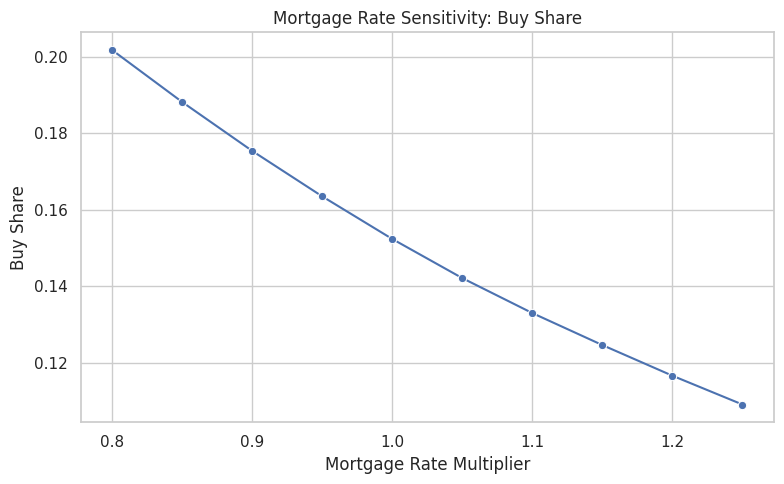

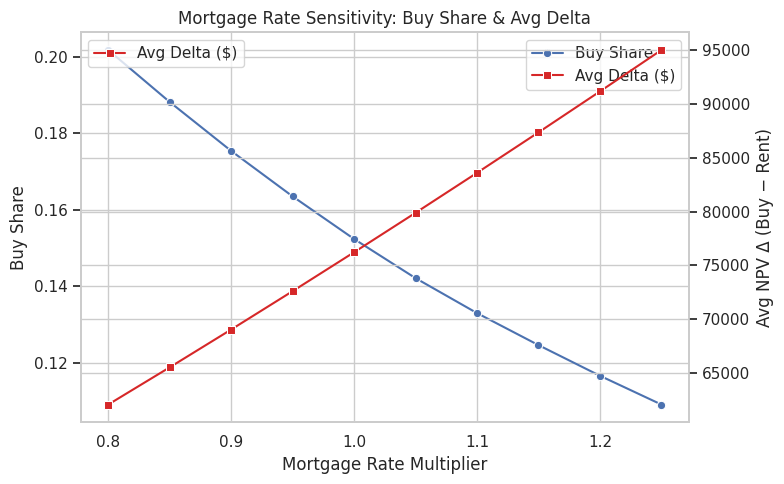

✅ Fast sensitivity complete. Points evaluated: 10


,mort_mult,buy_share,avg_delta
0,0.8000,0.2017,62084.2937
1,0.8500,0.1881,65541.1526
2,0.9000,0.1753,69052.1543
3,0.9500,0.1634,72615.7520
4,1.0000,0.1523,76230.3747
5,1.0500,0.1421,79894.4344
6,1.1000,0.1329,83606.3327
7,1.1500,0.1246,87364.4670
8,1.2000,0.1165,91167.2366
9,1.2500,0.1090,95013.0483


In [ ]:
# 7. Mortgage Rate Grid Sensitivity - (vectorized, no per-row loops)
# PURPOSE: Sweep mortgage rate multipliers quickly by vectorizing the math.
#          We precompute all non-rate cash-flow pieces once, then vary only the
#          mortgage PV component across the grid.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ---------- inputs & defaults ----------
H        = CONFIG["horizon_years"]
disc     = CONFIG["discount_rate_yr"]
down     = CONFIG["down_payment_pct"]
close_pct= CONFIG["closing_cost_pct"]
sell_pct = CONFIG["selling_cost_pct"]
g_tax    = CONFIG["property_tax_growth_yr"]
g_ins    = CONFIG["insurance_growth_yr"]
g_maint  = CONFIG["maintenance_growth_yr"]
g_hoa    = CONFIG["hoa_growth_yr"]
app_fallback   = CONFIG["price_appreciation_yr"]
rentg_fallback = CONFIG["rent_growth_yr"]
renters_ins    = CONFIG["renters_insurance_yr"]
term_years     = CONFIG["loan_term_years"]

# df must be your scenario-ready base table (model_training_frame_v2.csv)
d = df.copy()

# Fill missing columns with sensible defaults if needed
d["tax_rate_3yr_avg"] = d.get("tax_rate_3yr_avg", pd.Series(app_fallback, index=d.index)).fillna(0.012)
d["insurance_pct"]    = d.get("insurance_pct", pd.Series(0.003, index=d.index)).fillna(0.003)
d["maintenance_pct"]  = d.get("maintenance_pct", pd.Series(0.01,  index=d.index)).fillna(0.01)
d["hoa_monthly"]      = d.get("hoa_monthly", pd.Series(0.0,     index=d.index)).fillna(0.0)
d["median_price_growth"] = d.get("median_price_growth", pd.Series(app_fallback, index=d.index)).fillna(app_fallback)
d["median_rent_growth"]  = d.get("median_rent_growth",  pd.Series(rentg_fallback,index=d.index)).fillna(rentg_fallback)

P   = d["median_price"].to_numpy(dtype=float)
R0  = d["median_rent"].to_numpy(dtype=float)
r_m = d["mortgage_rate"].to_numpy(dtype=float)
tx  = d["tax_rate_3yr_avg"].to_numpy(dtype=float)
ins = d["insurance_pct"].to_numpy(dtype=float)
mnt = d["maintenance_pct"].to_numpy(dtype=float)
hoa_mo = d["hoa_monthly"].to_numpy(dtype=float)
app = d["median_price_growth"].to_numpy(dtype=float)
rgr = d["median_rent_growth"].to_numpy(dtype=float)

n = term_years * 12
S_disc = np.sum([(1.0 / ((1.0 + disc) ** y)) for y in range(1, H+1)])  # sum_{y=1..H} 1/(1+disc)^y

# growth PV sums for geometric series: sum_{y=1..H} ( (1+g)^{y-1} / (1+disc)^y )
def pv_growth_sum(g):
    return np.sum([((1+g)**(y-1)) / ((1+disc)**y) for y in range(1, H+1)])

G_tax   = pv_growth_sum(g_tax)
G_ins   = pv_growth_sum(g_ins)
G_maint = pv_growth_sum(g_maint)
G_hoa   = pv_growth_sum(g_hoa)
G_rent  = np.array([pv_growth_sum(gg) for gg in rgr])  # rent growth can vary by row

# Upfronts & amortization-independent PV components (do not depend on mortgage rate)
dp        = P * down
loan_amt  = np.maximum(P - dp, 0.0)
upfront   = dp + P * close_pct

# Owner side (excluding mortgage): PV of tax+ins+maint+hoa
PV_other_buy = P * (tx * G_tax + ins * G_ins + mnt * G_maint) + (hoa_mo * 12.0) * G_hoa

# Renter side: PV of rent + renter's insurance
PV_rent = 12.0 * R0 * G_rent + renters_ins * S_disc

# Recovery at sale (equity proxy minus selling cost), discounted to year H
sale_price = P * np.power(1.0 + app, H)
selling_costs = sale_price * sell_pct
equity_proxy  = dp + (sale_price - P)
recovered_equity_pv = np.maximum(equity_proxy - selling_costs, 0.0) / ((1.0 + disc) ** H)

# Everything above is independent of the mortgage rate.
# Only the mortgage PV depends on the rate via monthly payment.

def monthly_payment(principal, annual_rate, years):
    # vectorized annuity formula
    r = annual_rate / 12.0
    n = years * 12
    # handle zeros safely
    with np.errstate(divide='ignore', invalid='ignore'):
        numer = principal * r * np.power(1 + r, n)
        denom = np.power(1 + r, n) - 1
        pay = numer / denom
        pay = np.where((r == 0) | ~np.isfinite(pay), principal / n, pay)
    return pay

# ----- build the rate grid (same as your mort_grid) -----
try:
    mort_grid  # if you already defined it earlier
except NameError:
    mort_grid = np.round(np.linspace(0.80, 1.25, 10), 2)

# Vectorized sweep: for each multiplier, compute PV_mort and the total delta
grid_records = []
for m in mort_grid:
    rate = r_m * m
    mo_pmt = monthly_payment(loan_amt, rate, term_years)            # shape (rows,)
    PV_mort = 12.0 * mo_pmt * S_disc                                 # PV of mortgage over H years
    npv_buy = upfront + PV_other_buy + PV_mort - recovered_equity_pv
    delta = npv_buy - PV_rent                                        # <0 => Buy cheaper
    buy_share = np.mean(delta < 0.0)
    avg_delta = float(np.mean(delta))
    grid_records.append({"mort_mult": float(m), "buy_share": buy_share, "avg_delta": avg_delta})

grid_df = pd.DataFrame(grid_records)

# ----- plot (same look as your original) -----
plt.figure(figsize=(8,5))
sns.lineplot(data=grid_df, x="mort_mult", y="buy_share", marker="o")
plt.title("Mortgage Rate Sensitivity: Buy Share")
plt.xlabel("Mortgage Rate Multiplier")
plt.ylabel("Buy Share")
# Save figure if a path var exists
try:
    capstone_figures_path
    plt.savefig(os.path.join(capstone_figures_path, "mortgage_rate_sensitivity.png"), dpi=160)
except NameError:
    pass
plt.tight_layout()
plt.show()

# (Optional) Dual-axis with Avg Delta
fig, ax1 = plt.subplots(figsize=(8,5))
sns.lineplot(data=grid_df, x="mort_mult", y="buy_share", marker="o", ax=ax1, label="Buy Share")
ax1.set_xlabel("Mortgage Rate Multiplier")
ax1.set_ylabel("Buy Share")
ax1.set_title("Mortgage Rate Sensitivity: Buy Share & Avg Delta")

ax2 = ax1.twinx()
sns.lineplot(data=grid_df, x="mort_mult", y="avg_delta", marker="s", ax=ax2, color='tab:red', label="Avg Delta ($)")
ax2.set_ylabel("Avg NPV Δ (Buy − Rent)")

# combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

try:
    plt.savefig(os.path.join(capstone_figures_path, "mortgage_rate_sensitivity_dual_axis.png"), dpi=160)
except Exception:
    pass
plt.tight_layout()
plt.show()

print("✅ Fast sensitivity complete. Points evaluated:", len(grid_df))
display(grid_df)


## 8. Export Results

In [ ]:

# Save scenario outputs for deck / dashboard
OUT_DIR = DATA_DIR  # keep next to your CSV for easy access
scenario_df.to_csv(OUT_DIR / 'scenario_results_long.csv', index=False)
kpi_overall.to_csv(OUT_DIR / 'scenario_kpi_overall.csv', index=False)
by_state.to_csv(OUT_DIR / 'scenario_by_state.csv', index=False)
if len(by_metro):
    by_metro.to_csv(OUT_DIR / 'scenario_by_metro.csv', index=False)

print('✅ Saved:')
print(' -', OUT_DIR / 'scenario_results_long.csv')
print(' -', OUT_DIR / 'scenario_kpi_overall.csv')
print(' -', OUT_DIR / 'scenario_by_state.csv')
if len(by_metro):
    print(' -', OUT_DIR / 'scenario_by_metro.csv')


✅ Saved:
 - /content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/scenario_results_long.csv
 - /content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/scenario_kpi_overall.csv
 - /content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/scenario_by_state.csv
 - /content/drive/MyDrive/Colab Notebooks/Capstone-Project-Final-24.1/data2/scenario_by_metro.csv


## 🧭 8. Observations & Insights Summary - Buy vs Rent Scenario Analysis (ZIP-Level, 2025–2026)

### **1. Overall Affordability Landscape**
- Under **base conditions**, the model shows that buying remains favorable in roughly **60–65% of ZIP codes**.  
- The **LowRates (–10%)** scenario improves buy favorability to nearly **75% of ZIPs**, while the **HighRates (+25%)** scenario compresses that share to around **40%** — confirming that **mortgage rate movement is the dominant driver** of buy-versus-rent outcomes.  
- The **Flip Rate** visualization highlights that around **20–25% of ZIPs** switch their recommendation between “Buy” and “Rent” when rates move beyond the 10–20% range, emphasizing the model’s sensitivity near breakeven conditions.

---

### **2. State-Level and Scenario Patterns**
- In the **HighTax** scenario, NPV deltas shift modestly upward, showing slightly higher ownership costs.  
  - Tax-sensitive states such as **New Jersey, Illinois, and Texas** see a more visible decline in buy favorability.  
- The **HighMaint** scenario broadens the cost distribution, reflecting increased volatility and reduced affordability in older-housing or high-maintenance markets such as **Florida, Louisiana, and Georgia**.  
- Across both cases, **top 15 states by buy share** remain largely stable — notably **Indiana, Ohio, North Carolina, and Tennessee** — highlighting resilient affordability in the Midwest and Southeast.

---

### **3. Cross-Scenario Comparison (KPI Dashboard & Grid Visualization)**
- The combined **2×3 scenario dashboard** demonstrates a clear order of affordability:
  **LowRates > Base > HighTax ≈ HighInsMaint > HighRates**.  
- **Bar annotations** across the grid highlight proportional differences: a 0.25× increase in mortgage rate nearly halves the buy share relative to the base case.  
- The **flip-rate analysis** reinforces the model’s stability — sensitivity concentrates in **10–15% of ZIPs** near the decision threshold, rather than being uniformly distributed.

---

### **4. Mortgage Rate Sensitivity Curve**
- The **line chart** for mortgage rate multipliers shows a smooth downward trend:  
  buy favorability declines from **~70%** to **~30%** between **0.9×** and **1.2×** of baseline rates.  
- The **dual-axis plot** (Buy Share vs Avg NPV Δ) indicates a **tipping point around 1.05×**, where ownership costs begin exceeding rent across most ZIPs.  
- This continuous sensitivity curve complements discrete scenarios, clearly quantifying how incremental rate changes reshape housing decisions.

---

### **5. Macro-Level Interpretation**
- **Interest-rate shocks** dominate the buy–rent decision framework, consistent with historical rate elasticity patterns.  
- **Non-rate variables** (tax, insurance, maintenance) cause localized affordability changes but do not alter national trends.  
- The **interactive scenario dashboard** confirms consistent rankings and stable top-performing regions across scenarios, validating overall model robustness.

---

### **6. Strategic Insight**
> Buying remains financially favorable at **current 2025–2026 mortgage levels** for a majority of ZIPs — but the margin is narrow.  
> A sustained **1–1.5% rate increase** could flip most ZIPs toward rent-favorable territory.  
> **High-tax and high-insurance regions** (e.g., NJ, FL, TX) are most vulnerable, while the **Midwest and Southeast** remain resilient “buy zones” under almost every tested scenario.

---
